# Experimento 4: MC Básico

## Importações

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.colors import ListedColormap
import seaborn as sns
from typing import Dict, Tuple, List
from collections import defaultdict

## Ambiente: Navegação no Labirinto (gridworld)

In [10]:
class AmbienteNavegacaoLabirinto:
    def __init__(self, world_size, bad_states, target_states, allow_bad_entry=False, rewards=[-1, -1, 1, 0]):
        """
        Inicializa o ambiente de navegação em labirinto.

        Parâmetros:
        - world_size: tupla (n_linhas, n_colunas)
        - bad_states: lista de tuplas com coordenadas de estados penalizados
        - target_states: lista de tuplas com coordenadas dos estados de objetivo
        - allow_bad_entry: bool, se False impede entrada em estados ruins (rebote)
        - rewards: lista de recompensas com [r_boundary, r_bad, r_target, r_other]
        """
        self.n_rows, self.n_cols = world_size   # dimensões da grade do labirinto
        self.bad_states = set(bad_states)       # estados com penalidade alta
        self.target_states = set(target_states) # estados com recompensa alta
        self.allow_bad_entry = allow_bad_entry  # se o agente pode entrar em estados ruins

        # Recompensas definidas para cada tipo de transição
        self.r_boundary = rewards[0]  # tentar sair da grade
        self.r_bad = rewards[1]       # transição para estado ruim
        self.r_target = rewards[2]    # transição para estado alvo
        self.r_other = rewards[3]     # demais transições

        # Espaço de ações: dicionário com deslocamentos (linha, coluna)
        self.action_space = {
            0: (-1, 0),  # cima
            1: (1, 0),   # baixo
            2: (0, -1),  # esquerda
            3: (0, 1),   # direita
            4: (0, 0)    # permanecer no mesmo estado
        }

        # Espaço de recompensas: lista de recompensas possíveis
        self.recompensas_possiveis = np.array(sorted(set(rewards)))
        self.reward_map = {r: i for i, r in enumerate(self.recompensas_possiveis)}

        # número total de estados
        self.n_states = self.n_rows * self.n_cols

        # número total de ações
        self.n_actions = len(self.action_space)

        # número total de recompensas possíveis
        self.n_rewards = self.recompensas_possiveis.shape[0]

        # Tensor de probabilidades de transição: P(s'|s,a)
        self.state_transition_probabilities = np.zeros((self.n_states, self.n_states, self.n_actions))

        # Tensor de probabilidade de recompensas: P(r|s,a)
        self.reward_probabilities = np.zeros((self.n_rewards, self.n_states, self.n_actions))

        # Matriz de recompensa imediata (determinística): recompensa[s, a] = r
        self.recompensas_imediatas = np.zeros((self.n_states, self.n_actions))

        # Matriz de transição de estados (determinística): transicao[s, a] = s'
        self.transicao_de_estados = np.zeros((self.n_states, self.n_actions), dtype=int)

        self.agent_pos = (0, 0)  # posição inicial do agente

        self._init_dynamics()  # inicializa as dinâmicas de transição e recompensa


    def _init_dynamics(self):
        """
        Preenche as matrizes de transição e recompensa com base
        na estrutura do ambiente e regras de movimentação.
        """
        for indice_estado in range(self.n_states):
            estado_atual = self.index_to_state(indice_estado)

            for acao, (d_linha, d_coluna) in self.action_space.items():
                proxima_posicao = (estado_atual[0] + d_linha, estado_atual[1] + d_coluna)

                # Verifica se o movimento é válido ou resulta em rebote
                if not self._in_bounds(proxima_posicao) or (not self.allow_bad_entry and proxima_posicao in self.bad_states):
                    proximo_estado = estado_atual  # rebote: permanece no estado atual
                else:
                    proximo_estado = proxima_posicao

                # Calcula a recompensa imediata da transição (s, a)
                recompensa = self._compute_reward(proxima_posicao)

                # Armazena a recompensa imediata na matriz
                self.recompensas_imediatas[indice_estado, acao] = recompensa

                # Ambiente determinístico
                indice_proximo = self.state_to_index(proximo_estado)
                self.state_transition_probabilities[indice_proximo, indice_estado, acao] = 1.0  # registra probabilidade P(s'|s,a)
                indice_recompensa = self.reward_map[recompensa]
                self.reward_probabilities[indice_recompensa, indice_estado, acao] = 1.0  # registra probabilidade P(r|s,a)

                # Armazena transição determinística (s, a) -> s'
                self.transicao_de_estados[indice_estado, acao] = indice_proximo


    def reset(self):
        """Reinicia a posição do agente para o estado inicial (0, 0)."""
        self.agent_pos = (0, 0)
        return self.agent_pos


    def step(self, acao):
        """
        Executa uma ação no ambiente e atualiza a posição do agente.

        Parâmetros:
        - acao: índice da ação a ser executada (0 a 4)

        Retorna:
        - nova posição do agente (linha, coluna)
        - recompensa recebida
        """
        d_linha, d_coluna = self.action_space[acao]
        linha_destino = self.agent_pos[0] + d_linha
        coluna_destino = self.agent_pos[1] + d_coluna
        destino = (linha_destino, coluna_destino)

        # Se movimento for inválido ou entrada proibida, permanece
        if not self._in_bounds(destino) or (not self.allow_bad_entry and destino in self.bad_states):
            destino = self.agent_pos

        recompensa = self._compute_reward(destino)
        self.agent_pos = destino
        return self.agent_pos, recompensa


    def _in_bounds(self, posicao):
        """Verifica se uma posição está dentro dos limites do labirinto."""
        linha, coluna = posicao
        return 0 <= linha < self.n_rows and 0 <= coluna < self.n_cols


    def _compute_reward(self, destino):
        """
        Define a recompensa com base no destino proposto:
        - r_boundary: fora do grid
        - r_bad: célula ruim
        - r_target: célula alvo
        - r_other: demais casos
        """
        if not self._in_bounds(destino):
            return self.r_boundary
        elif destino in self.bad_states:
            return self.r_bad
        elif destino in self.target_states:
            return self.r_target
        else:
            return self.r_other


    def reset_to_state(self, state, verify_bounds: bool = True):
        """
        Teleporta o agente para 'state' sem reiniciar o episódio completo.

        Parâmetros
        ----------
        state : (int, int) | int
            - Tupla (linha, coluna)
            ou
            - Índice linear (int)
        verify_bounds : bool
            Se True, lança ValueError se o estado não for válido.

        Retorna
        -------
        observation : object
            A observação correspondente ao novo estado (a própria posição).
        """
        # Converte índice -> tupla, se necessário
        if isinstance(state, int):
            state = self.index_to_state(state)

        if verify_bounds and not self._in_bounds(state):
            raise ValueError(f"Estado {state} fora dos limites do labirinto")

        self.agent_pos = tuple(state)      # mantém tupla imutável

        return self.agent_pos


    def state_to_index(self, estado):
        """Converte coordenada (linha, coluna) para índice linear."""
        linha, coluna = estado
        return linha * self.n_cols + coluna


    def index_to_state(self, indice):
        """Converte índice linear para coordenada (linha, coluna)."""
        return divmod(indice, self.n_cols)  # (linha, coluna) = (indice // self.n_cols, indice % self.n_cols)

\## Funções auxiliares para visualização

In [11]:
def plot_policy(env, policy, ax=None, titulo="Política"):
    _, ax = _prepare_grid(env, ax=ax)

    for (r, c), action in policy.items():
        x, y = c + 0.5, r + 0.5
        color = 'black'
        lw = 1.5

        if action == 0:
            ax.arrow(x, y, dx=0, dy=-0.3, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 1:
            ax.arrow(x, y, dx=0, dy=0.3, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 2:
            ax.arrow(x, y, dx=-0.3, dy=0, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 3:
            ax.arrow(x, y, dx=0.3, dy=0, head_width=0.2, head_length=0.2, fc=color, ec=color, linewidth=lw)
        elif action == 4:
            circ = patches.Circle((x, y), 0.1, edgecolor=color, facecolor='none', linewidth=lw)
            ax.add_patch(circ)

    ax.set_title(titulo)
    if ax is None:
        plt.show()


def _prepare_grid(env, ax=None, draw_cells=True):
    if ax is None:
        fig, ax = plt.subplots(figsize=(env.n_cols, env.n_rows))
    ax.set_xlim(0, env.n_cols)
    ax.set_ylim(0, env.n_rows)
    ax.set_xticks(np.arange(0, env.n_cols + 1, 1))
    ax.set_yticks(np.arange(0, env.n_rows + 1, 1))
    ax.grid(True)
    ax.set_aspect('equal')
    ax.invert_yaxis()

    if draw_cells:
        for r in range(env.n_rows):
            for c in range(env.n_cols):
                cell = (r, c)
                if cell in env.bad_states:
                    color = 'red'
                elif cell in env.target_states:
                    color = 'green'
                else:
                    color = 'white'
                rect = patches.Rectangle(xy=(c, r), width=1, height=1, facecolor=color, edgecolor='gray')
                ax.add_patch(rect)

    return (None, ax) if ax else (fig, ax)

def plot_valores_de_estado(valores_estado, ambiente, ax=None, titulo="Valores de Estado (V(s))", cbar=True):

    dados = valores_estado.reshape(ambiente.n_rows, ambiente.n_cols)

    if ax is None:
        fig, ax = plt.subplots(figsize=(ambiente.n_cols, ambiente.n_rows))

    sns.heatmap(
        data=dados,
        annot=True,
        fmt='.1f',
        cmap='bwr',
        square=True,
        cbar=cbar,
        linewidths=0.5,
        linecolor='gray',
        ax=ax
    )
    ax.set_title(titulo)
    if ax is None:
        plt.tight_layout()
        plt.show()



def plot_valores_de_acao(valores_de_acao):
    Q_transposta = valores_de_acao.T
    n_acoes, n_estados = Q_transposta.shape

    plt.figure(figsize=(n_estados, n_acoes))
    ax = sns.heatmap(
        Q_transposta,
        annot=True,
        fmt='.1f',
        cmap='bwr',
        cbar=True,
        square=False,
        linewidths=0.5,
        linecolor='gray'
    )
    # Rótulos das colunas (estados)
    ax.set_xticks(np.arange(n_estados) + 0.5)
    ax.set_xticklabels([f"s{i}" for i in range(n_estados)], rotation=0)

    # Rótulos das linhas (ações)
    ax.set_yticks(np.arange(n_acoes) + 0.5)
    ax.set_yticklabels([f"a{i}" for i in range(n_acoes)], rotation=0)

    ax.set_xlabel(r"Estados")
    ax.set_ylabel(r"Ações")
    ax.set_title(r"Valores de ação (Q(s, a) transposta)")
    plt.tight_layout()
    plt.show()


def plot_labirinto(ambiente):
    """
    Visualiza o labirinto usando seaborn.heatmap sem ticks nos eixos.

    Representa:
    - Estado neutro: branco
    - Estado ruim: vermelho
    - Estado alvo: verde
    """
    # Cria matriz com valores padrão (0 = neutro)
    matriz = np.zeros((ambiente.n_rows, ambiente.n_cols), dtype=int)

    # Marca os estados ruins como 1
    for (r, c) in ambiente.bad_states:
        matriz[r, c] = 1

    # Marca os estados alvo como 2
    for (r, c) in ambiente.target_states:
        matriz[r, c] = 2

    # Mapa de cores: branco = neutro, vermelho = ruim, verde = alvo
    cmap = ListedColormap(["white", "red", "green"])

    plt.figure(figsize=(ambiente.n_cols, ambiente.n_rows))
    ax = sns.heatmap(
        matriz,
        cmap=cmap,
        cbar=False,
        linewidths=0.5,
        linecolor='gray',
        square=True
    )

    # Remove todos os ticks e labels
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels([])
    ax.set_yticklabels([])

    ax.set_title("Visualização do Labirinto")
    plt.tight_layout()
    plt.show()

## MC Básico

In [12]:
def gerar_episodio(
    ambiente,
    estado_inicial: int,
    acao_inicial: int,
    politica: Dict[Tuple[int, int], int],
    T: int,
    gamma: float,
) -> float:
    """
    Executa um episódio Monte Carlo de comprimento fixo T.

    Parâmetros
    ----------
    ambiente : AmbienteNavegacaoLabirinto
        Instância do gridworld.
    estado_inicial : int
        Índice linear do estado onde o episódio começa.
    acao_inicial   : int
        Ação forçada no primeiro passo -> necessária para cobrir todo par (s,a).
    politica       : Dict[(int,int), int]
        Política seguida a partir do segundo passo.
    T              : int
        Horizonte fixo (número máximo de passos do episódio).
    gamma          : float
        Fator de desconto (0 < gamma ≤ 1).

    Retorna
    -------
    G : float
        Retorno.
    """
    
    # Converte estado inicial de índice para coordenadas
    estado_inicial_coords = ambiente.index_to_state(estado_inicial)
    
    # Reseta o ambiente para o estado inicial
    ambiente.reset_to_state(estado_inicial_coords)
    
    # Lista para armazenar as recompensas do episódio
    recompensas = []
    
    # Primeiro passo: executa a ação inicial forçada
    _, recompensa = ambiente.step(acao_inicial)
    recompensas.append(recompensa)
    
    # Passos subsequentes: segue a política
    for t in range(1, T):
        estado_atual = ambiente.agent_pos
        
        # Verifica se existe ação definida na política para este estado
        if estado_atual in politica:
            acao = politica[estado_atual]
        else:
            # Se não existe, escolhe ação aleatória (ou ação padrão)
            acao = np.random.choice(ambiente.n_actions)
        
        # Executa a ação
        _, recompensa = ambiente.step(acao)
        recompensas.append(recompensa)
    
    # Calcula o retorno descontado G = sum(gamma^t * r_t)
    G = 0.0
    for t, r in enumerate(recompensas):
        G += (gamma ** t) * r
    
    return G


def avaliar_politica_mc(
    ambiente,
    politica: Dict[Tuple[int, int], int],
    gamma: float,
    horizonte_T: int,
    episodios_por_sa: int,
) -> np.ndarray:
    """
    Estima Q(s,a) por Monte Carlo com episódios de horizonte fixo T.

    Parâmetros
    ----------
    ambiente         : AmbienteNavegacaoLabirinto
        Instância do gridworld.
    politica         : Dict[(int,int), int]
        Política determinística a ser avaliada.
    gamma            : float
        Fator de desconto.
    horizonte_T      : int
        Comprimento dos episódios.
    episodios_por_sa : int
        Quantas amostras gerar para cada par (s,a).

    Retorna
    -------
    Q : np.ndarray (n_estados, n_acoes)
        Estimativa dos valores-ação Q_π(s,a).
    """
    
    # Inicializa a matriz Q com zeros
    Q = np.zeros((ambiente.n_states, ambiente.n_actions))
    
    # Para cada par (estado, ação)
    for s in range(ambiente.n_states):
        for a in range(ambiente.n_actions):
            # Gera múltiplos episódios para este par (s,a)
            retornos = []
            
            for _ in range(episodios_por_sa):
                # Gera um episódio começando no estado s com ação a
                G = gerar_episodio(
                    ambiente=ambiente,
                    estado_inicial=s,
                    acao_inicial=a,
                    politica=politica,
                    T=horizonte_T,
                    gamma=gamma
                )
                retornos.append(G)
            
            # Estima Q(s,a) como a média dos retornos
            Q[s, a] = np.mean(retornos)
    
    return Q


def melhorar_politica(
    ambiente,
    Q: np.ndarray,
    politica_antiga: Dict[Tuple[int, int], int],
) -> Tuple[Dict, bool]:
    """
    Gera a nova política gulosa em relação a Q e informa se a política estabilizou.

    Parâmetros
    ----------
    ambiente : AmbienteNavegacaoLabirinto
        Instância do gridworld.
    Q        : np.ndarray (n_estados, n_acoes)
        Valores-ação estimados.
    politica_antiga: Dict[(int,int), int]
        Política usada na avaliação anterior.

    Retorna
    -------
    politica_nova    : Dict[(int,int), int]
    politica_estavel : bool
        True se politica_nova == politica_antiga (critério de convergência).
    """
    
    politica_nova = {}
    
    # Para cada estado, escolhe a ação com maior valor Q
    for s in range(ambiente.n_states):
        estado_coords = ambiente.index_to_state(s)
        
        # Encontra a ação com maior valor Q(s,a)
        melhor_acao = np.argmax(Q[s, :])
        politica_nova[estado_coords] = melhor_acao
    
    # Verifica se a política mudou
    politica_estavel = (politica_nova == politica_antiga)
    
    return politica_nova, politica_estavel


def mc_basico(
    ambiente,
    gamma: float = 0.9,
    episodios_por_par_s_a: int = 1,
    max_iter: int = 50,
    horizonte_T: int = 50,
) -> Tuple[np.ndarray, np.ndarray]:
    """
    Implementação do MC Basic.

    O método alterna entre 2 etapas:

    1. Avaliação de política
       Estima Q(s,a) pela média dos retornos de 'episodios_por_par_s_a' episódios Monte-Carlo,
       cada um com comprimento exatamente 'horizonte_T' passos (primeira ação forçada para garantir inícios exploratórios).

    2. Melhoria de política
       Torna a política determinística e gulosa em relação às estimativasobtidas.
       O processo repete-se até que a política não mude ou até atingir 'max_iter' iterações.

    ----------
    Parâmetros
    ----------
    ambiente : AmbienteNavegacaoLabirinto
        Instância do gridworld.
    gamma : float, opcional
        Fator de desconto (0 < gamma <= 1).
    episodios_por_par_s_a : int, opcional
        Número de episódios gerados para cada par (s,a) na etapa de avaliação de política.
    max_iter : int, opcional
        Critério de parada: máximo de iterações da iteração de política antes de forçar parada.
    horizonte_T : int, opcional
        Comprimento fixo dos episódios Monte-Carlo.

    ----------
    Retorno
    -------
    Q : np.ndarray, shape = (n_states, n_actions)
        Estimativa de Q(s,a).
    politica : Dict[(int,int), int]
        Política ótima encontrada, mapeando cada coordenada (linha,coluna) para o índice da ação ótima.
    iteracoes : int
        Número de iterações realmente  (iteracoes <= max_iter).
    """
    
    # Inicializa política aleatória
    politica = {}
    for s in range(ambiente.n_states):
        estado_coords = ambiente.index_to_state(s)
        politica[estado_coords] = np.random.choice(ambiente.n_actions)
    
    # Loop principal do Monte Carlo Básico
    for k in range(max_iter):
        #print(f"Iteração {k+1}/{max_iter}")
        
        # Etapa 1: Avaliação da política
        Q = avaliar_politica_mc(
            ambiente=ambiente,
            politica=politica,
            gamma=gamma,
            horizonte_T=horizonte_T,
            episodios_por_sa=episodios_por_par_s_a
        )
        
        # Etapa 2: Melhoria da política
        politica_nova, politica_estavel = melhorar_politica(
            ambiente=ambiente,
            Q=Q,
            politica_antiga=politica
        )
        
        # Atualiza a política
        politica = politica_nova
        
        # Verifica convergência
        if politica_estavel:
            print(f"Política convergiu na iteração {k+1}")
            break
    
    return Q, politica, k + 1

## Ambiente

In [13]:
# Instancia o ambiente
ambiente = AmbienteNavegacaoLabirinto(
        world_size=(5, 5),
        bad_states=[(1, 1), (1, 2), (2, 2), (3, 1), (3, 3), (4, 1)],
        target_states=[(3, 2)],
        allow_bad_entry=True,           # permite entrar em estados ruins
        rewards=[-1, -10, 1, 0]
    )

## Experimento

Política convergiu na iteração 13
Política estável após 13 iterações.


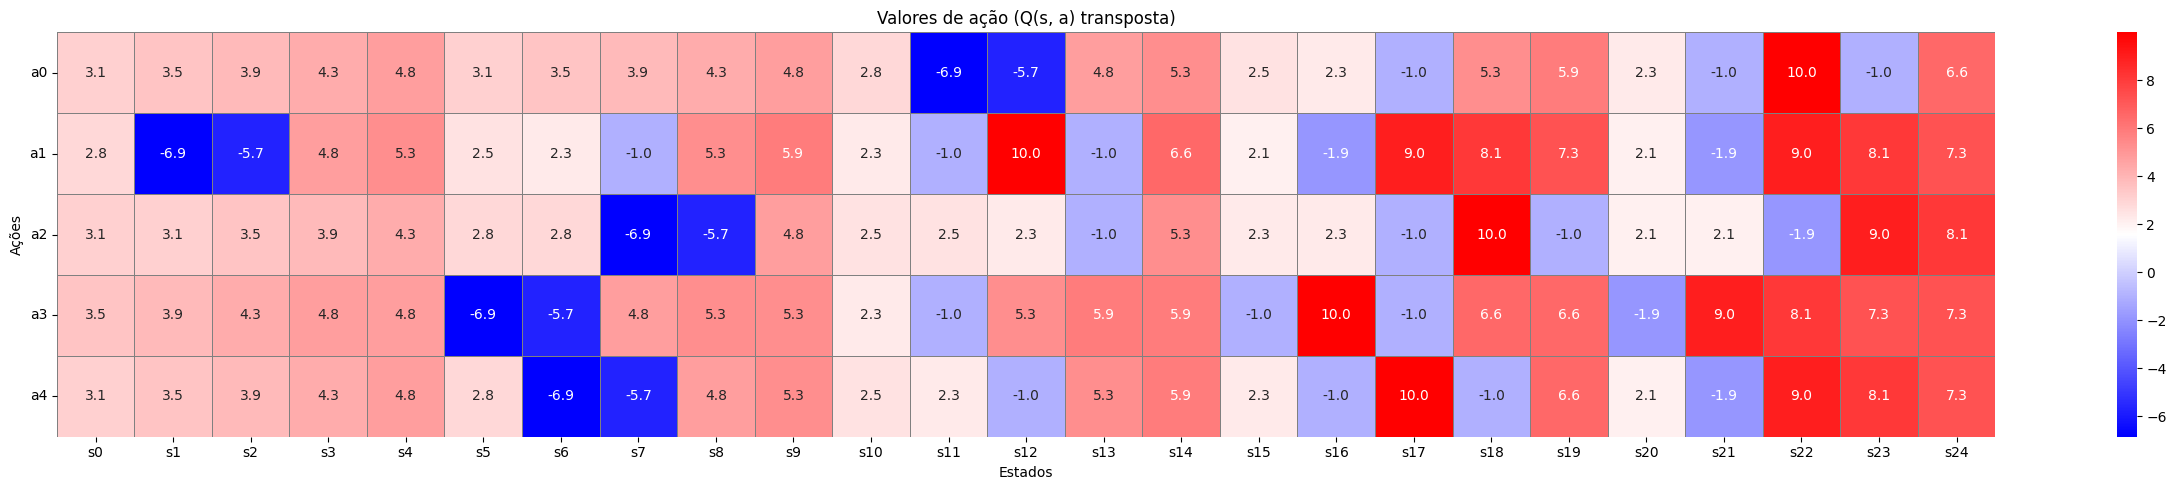

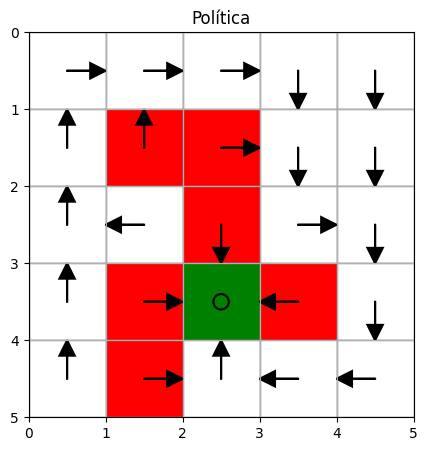

In [14]:
q_opt, pi_opt, n_iter = mc_basico(
    ambiente,
    gamma=0.9,  # taxa de desconto
    episodios_por_par_s_a=1,  # episódios por par de estados e ações
    max_iter=100,  # número máximo de iterações
    horizonte_T=100  # horizonte de tempo
)

print(f"Política estável após {n_iter} iterações.")

plot_valores_de_acao(q_opt)

plot_policy(ambiente, pi_opt)

# Teste de hiperparâmetros

In [17]:
# ambiente

# Instancia o ambiente
ambiente = AmbienteNavegacaoLabirinto(
        world_size=(5, 5),
        bad_states=[(1, 1), (1, 2), (2, 2), (3, 1), (3, 3), (4, 1)],
        target_states=[(3, 2)],
        allow_bad_entry=True,           # permite entrar em estados ruins
        rewards=[-1, -10, 1, 0]
    )

## Gamma


Avaliação com gamma = 0.1
Política convergiu na iteração 11
Política estável após 11 iterações.


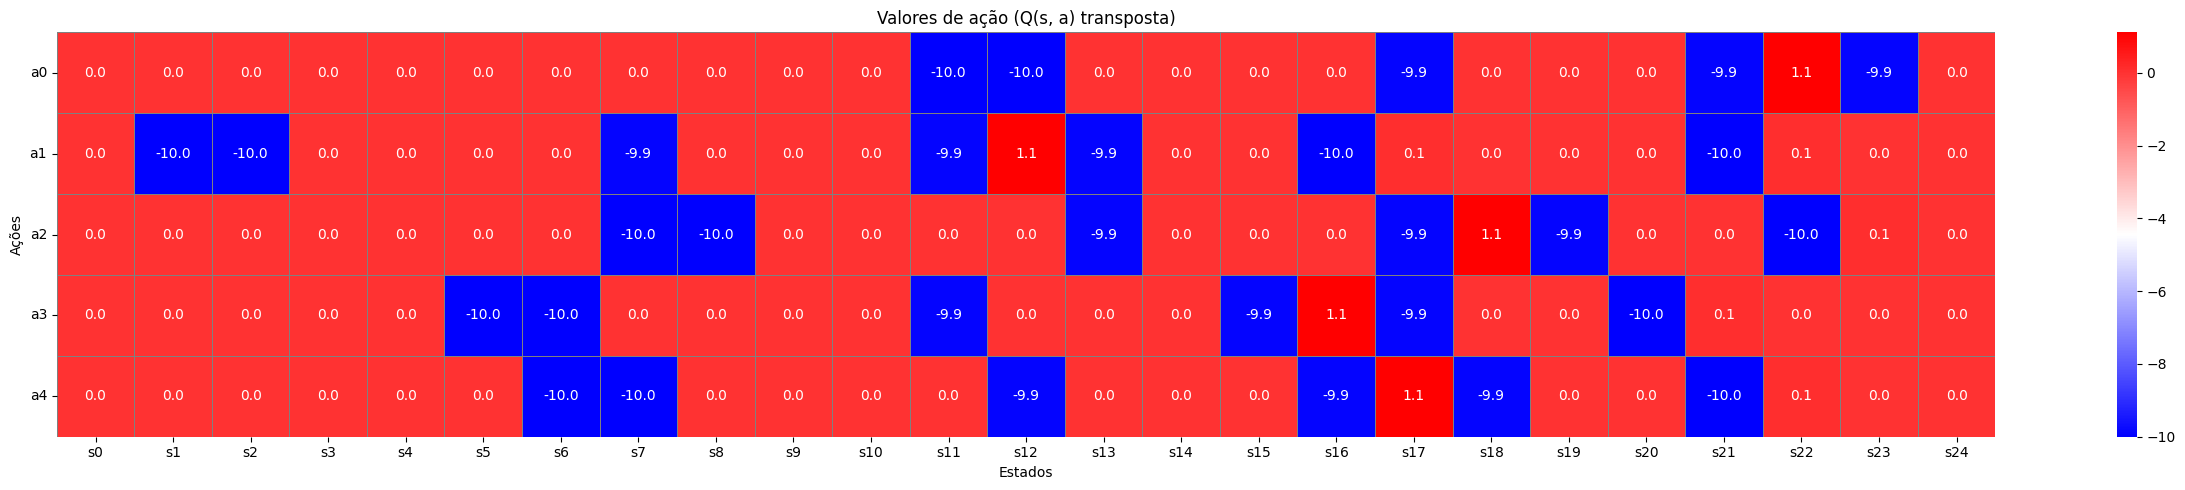


Avaliação com gamma = 0.5
Política convergiu na iteração 12
Política estável após 12 iterações.


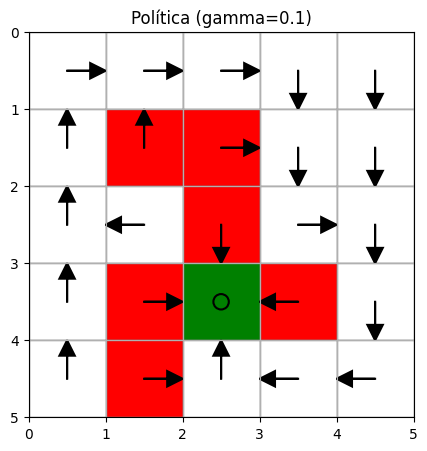

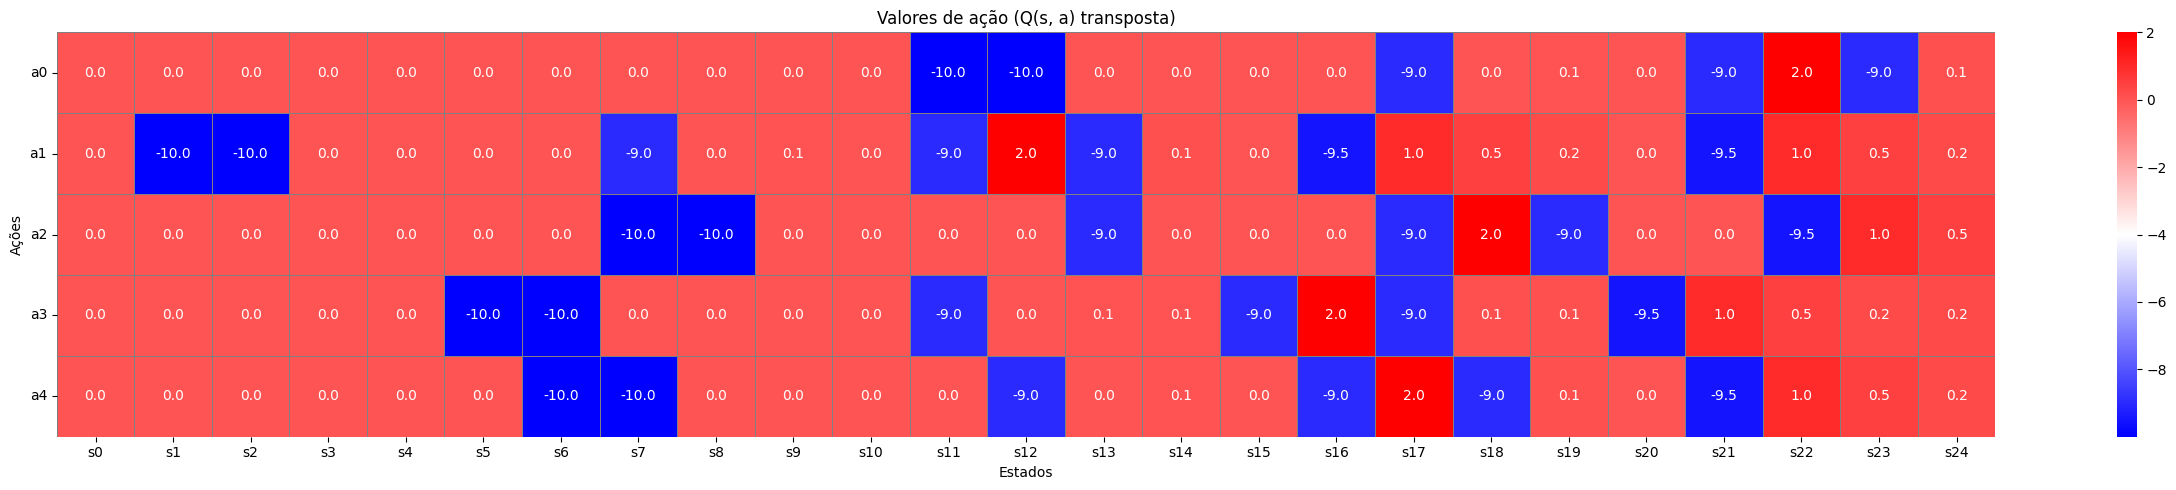


Avaliação com gamma = 0.9
Política convergiu na iteração 14
Política estável após 14 iterações.


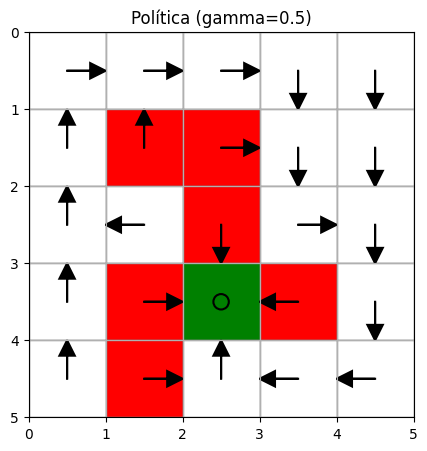

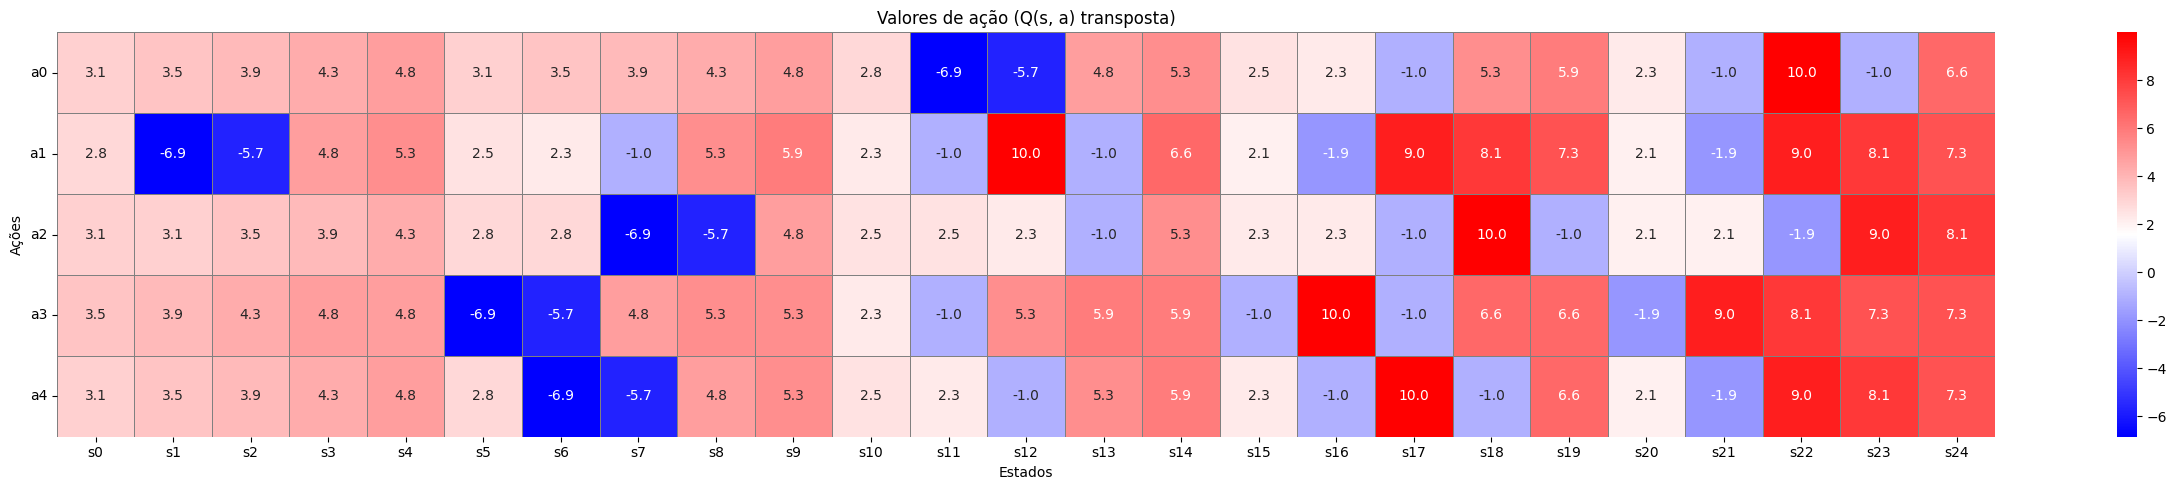


Avaliação com gamma = 0.99
Política convergiu na iteração 10
Política estável após 10 iterações.


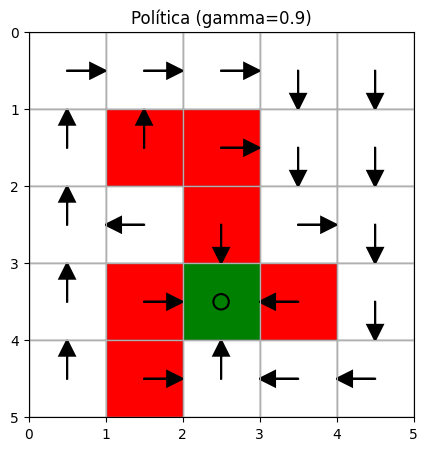

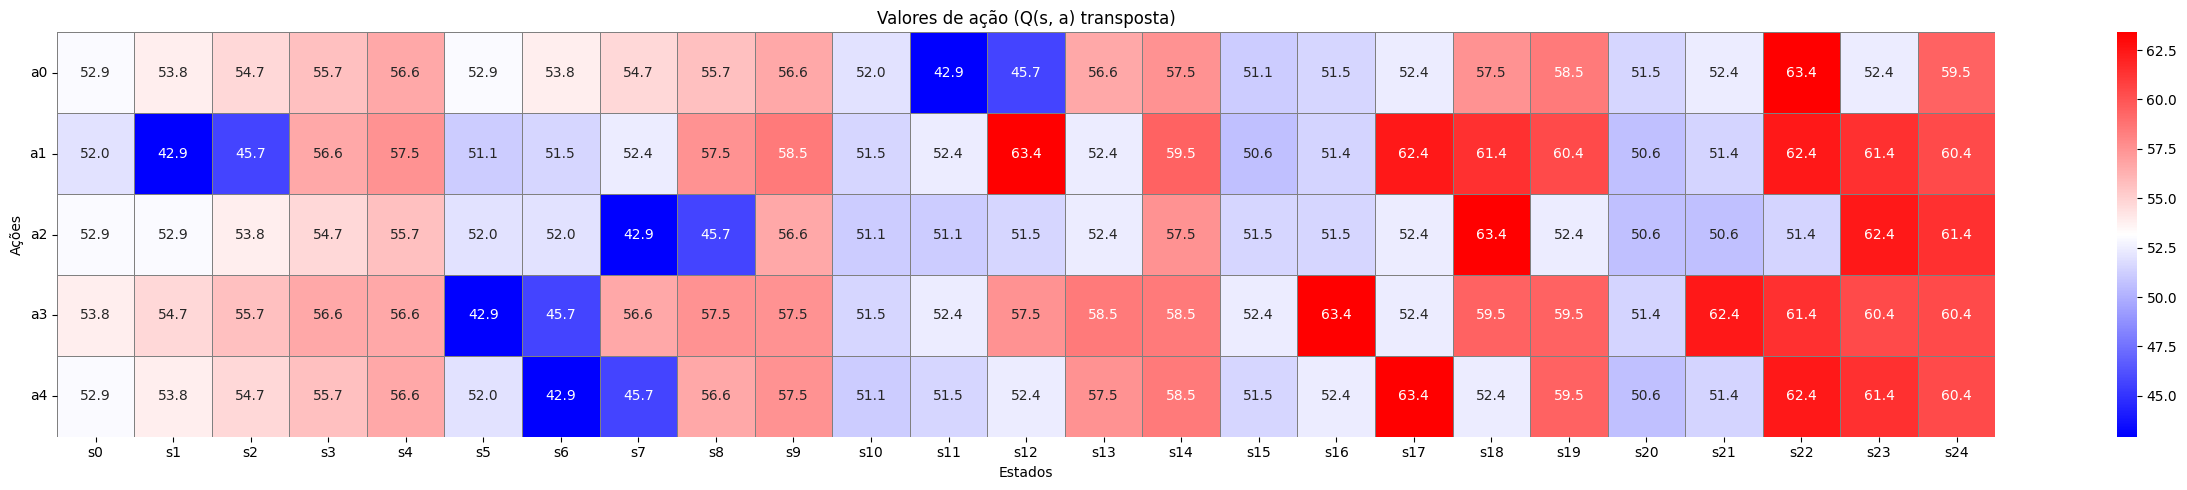

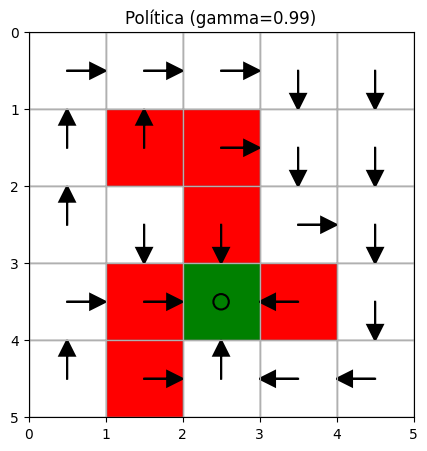

In [ ]:
gammas = [0.1, 0.5, 0.9, 0.99]

for i, gamma in enumerate(gammas):
    print(f"\nAvaliação com gamma = {gamma}")
    q_opt, pi_opt, n_iter = mc_basico(
        ambiente,
        gamma=gamma,
        episodios_por_par_s_a=1,
        max_iter=100,
        horizonte_T=100
    )
    print(f"Política estável após {n_iter} iterações.")
    plot_valores_de_acao(q_opt)
    plot_policy(ambiente, pi_opt, titulo=f"Política (gamma={gamma})")


## Episódios por Par Estado-Ação


Avaliação com 1 episódios por par (s,a)
Política convergiu na iteração 12
Política estável após 12 iterações.


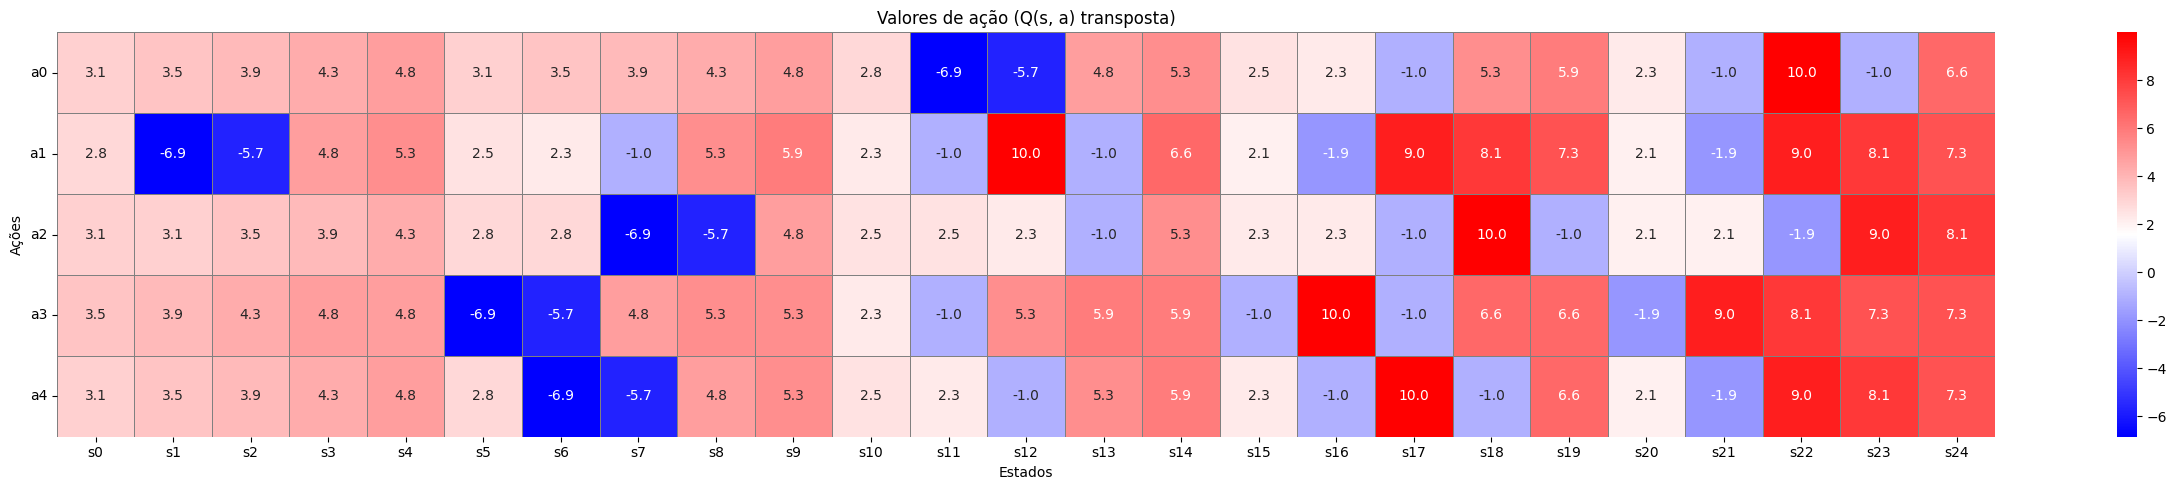


Avaliação com 5 episódios por par (s,a)
Política convergiu na iteração 13
Política estável após 13 iterações.


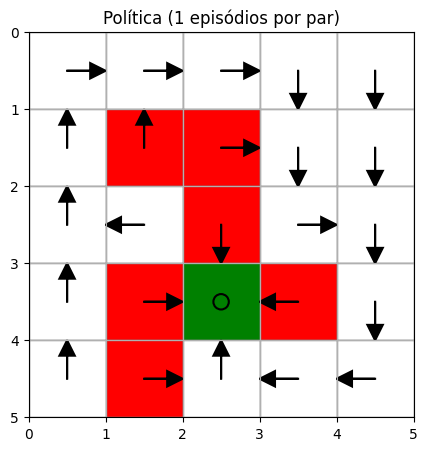

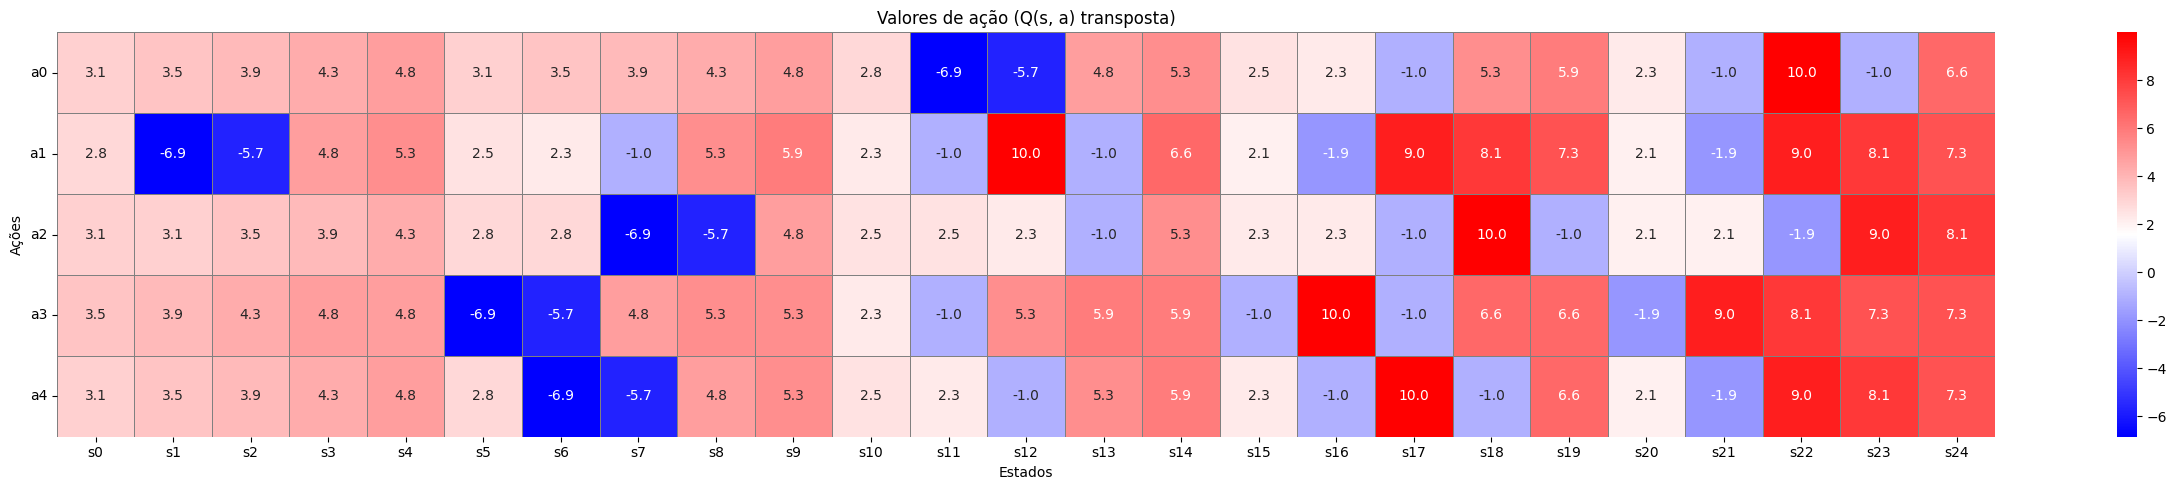


Avaliação com 10 episódios por par (s,a)
Política convergiu na iteração 13
Política estável após 13 iterações.


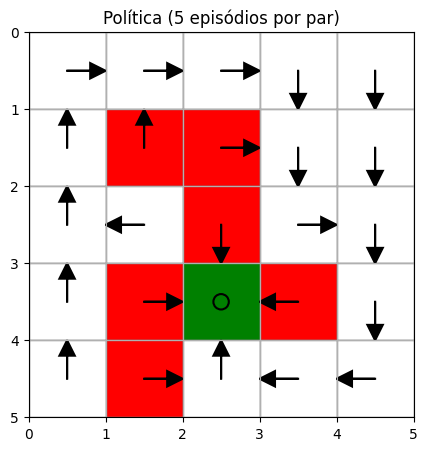

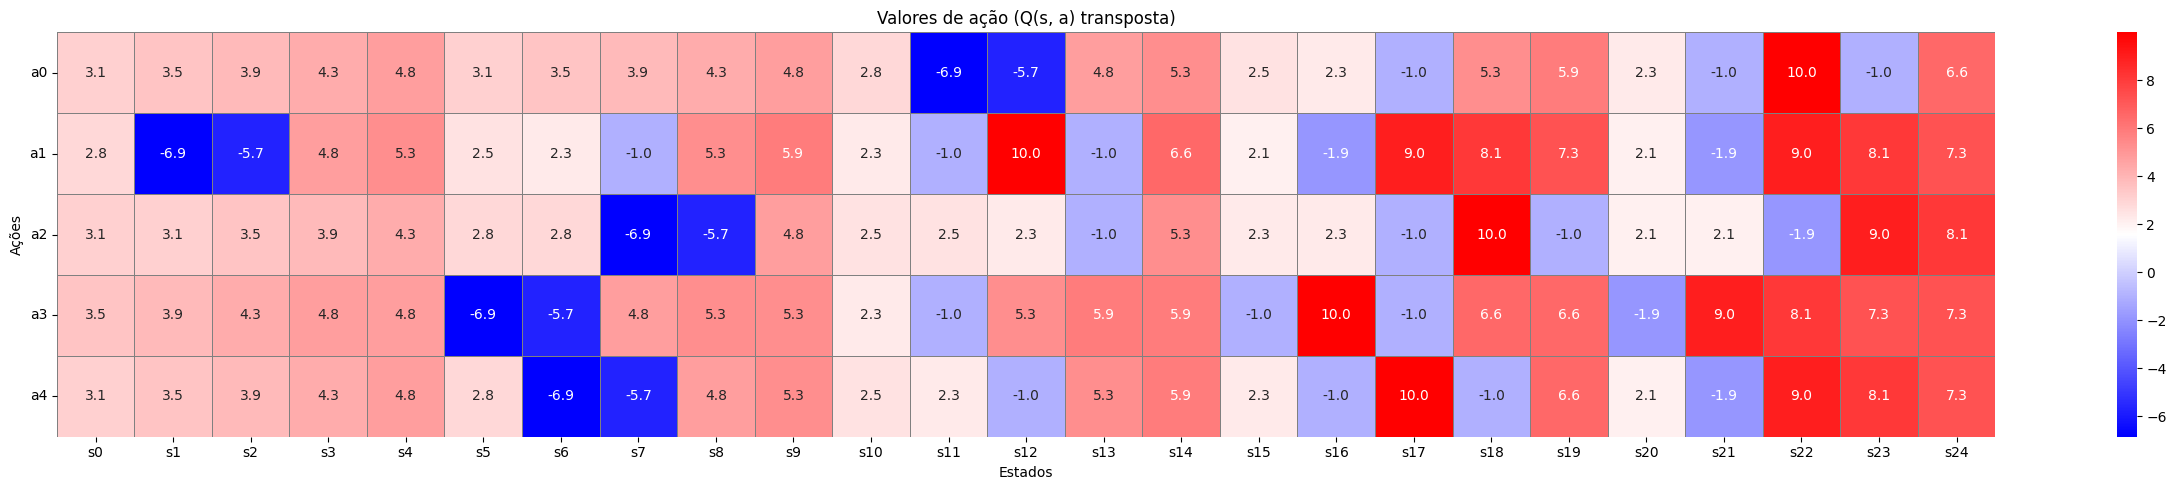


Avaliação com 50 episódios por par (s,a)
Política convergiu na iteração 13
Política estável após 13 iterações.


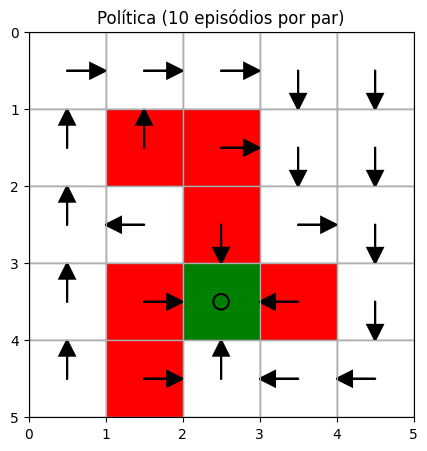

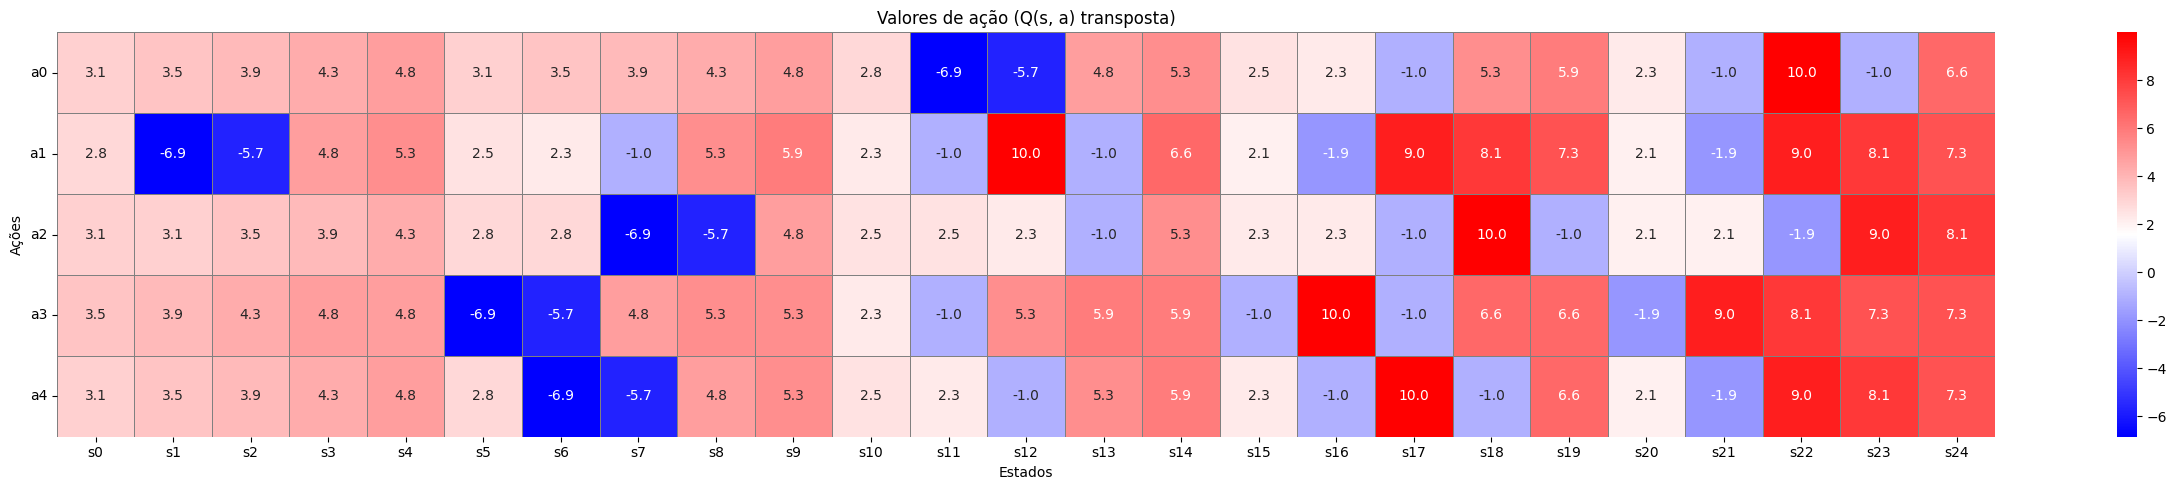


Avaliação com 100 episódios por par (s,a)
Política convergiu na iteração 13
Política estável após 13 iterações.


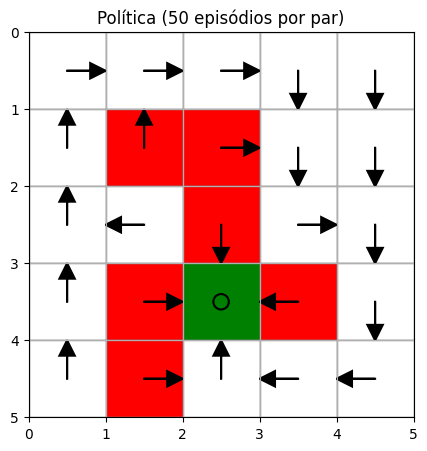

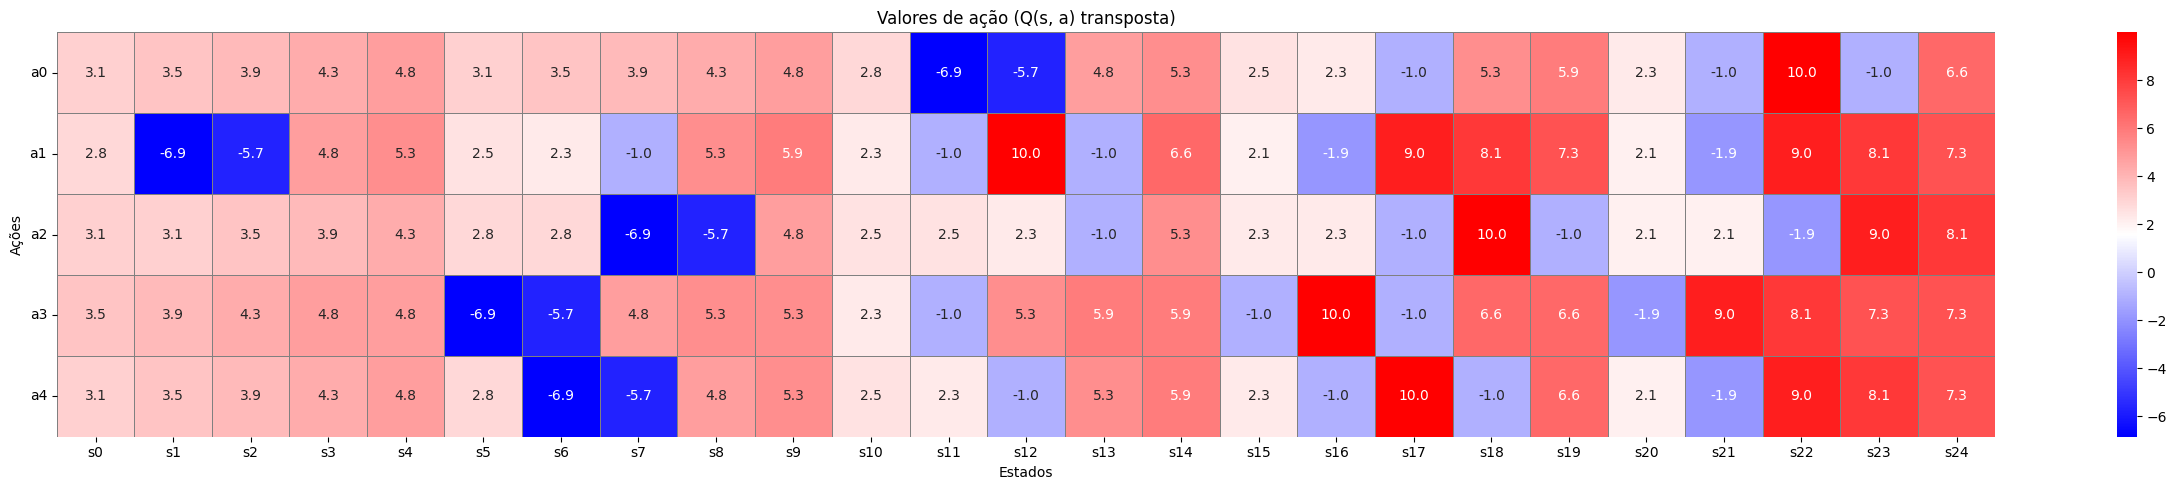

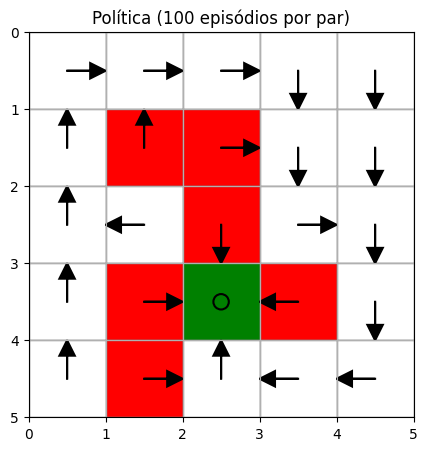

In [ ]:
episodios_por_par_s_a = [1, 5, 10, 50, 100]

for i, n_episodios in enumerate(episodios_por_par_s_a):
    print(f"\nAvaliação com {n_episodios} episódios por par (s,a)")
    q_opt, pi_opt, n_iter = mc_basico(
        ambiente,
        gamma=0.9,
        episodios_por_par_s_a=n_episodios,
        max_iter=100,
        horizonte_T=100
    )
    print(f"Política estável após {n_iter} iterações.")
    plot_valores_de_acao(q_opt)
    plot_policy(ambiente, pi_opt, titulo=f"Política ({n_episodios} episódios por par)")


## Horizonte T


Avaliação com horizonte T = 1
Política convergiu na iteração 2
Política estável após 2 iterações.


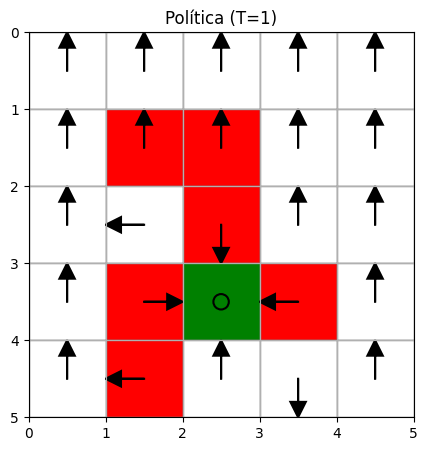

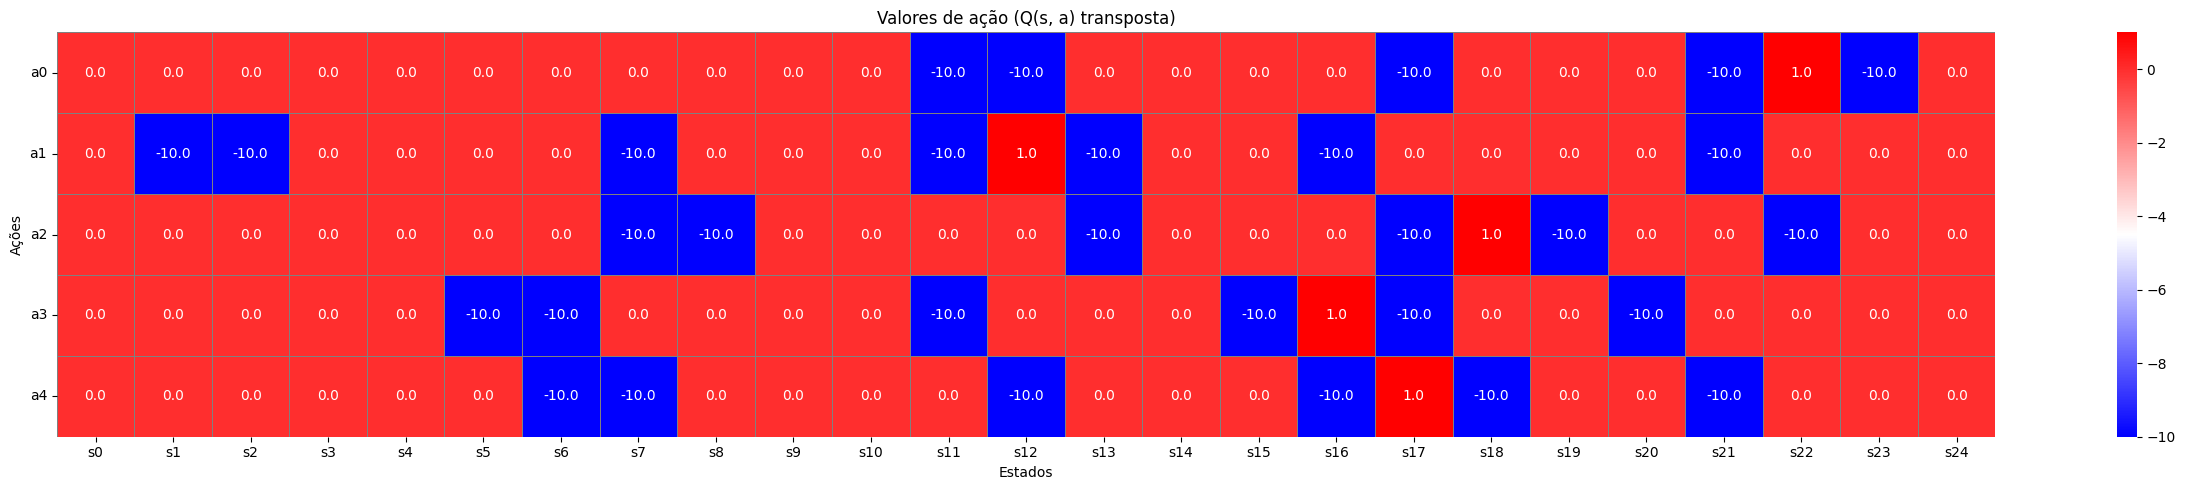


Avaliação com horizonte T = 5
Política convergiu na iteração 7
Política estável após 7 iterações.


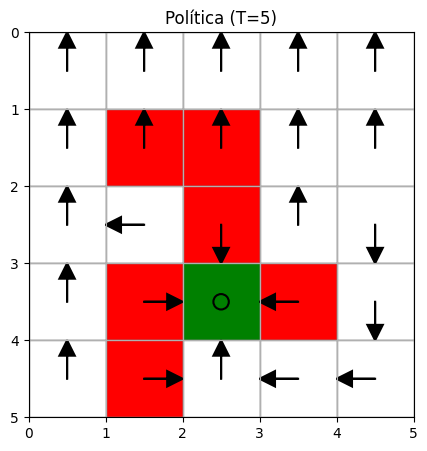

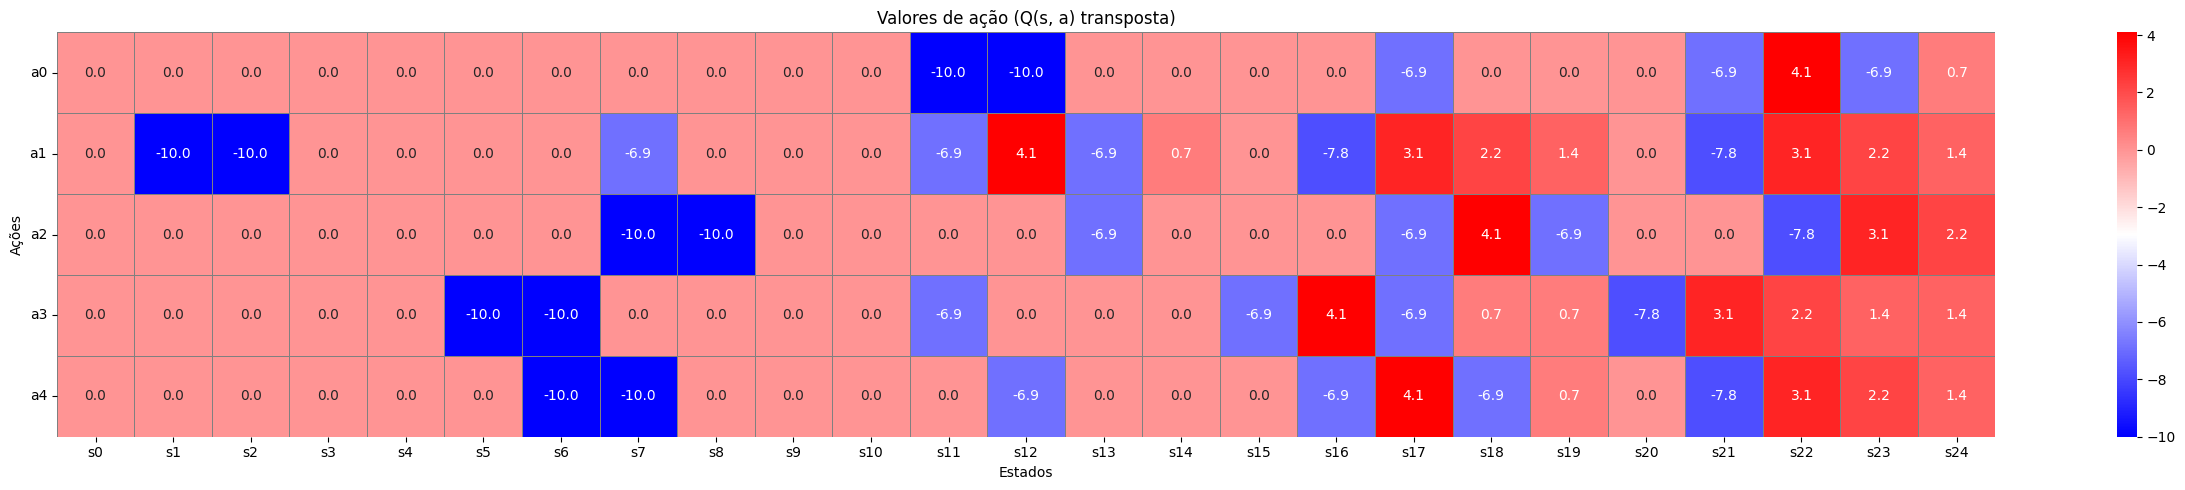


Avaliação com horizonte T = 10
Política convergiu na iteração 13
Política estável após 13 iterações.


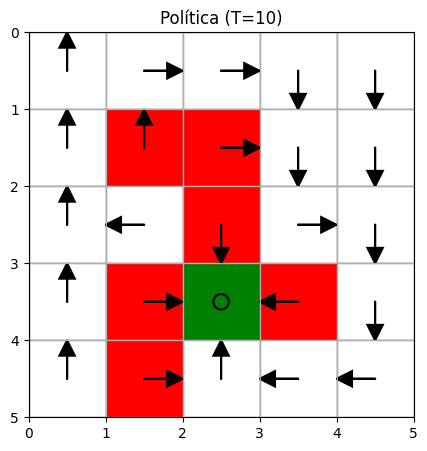

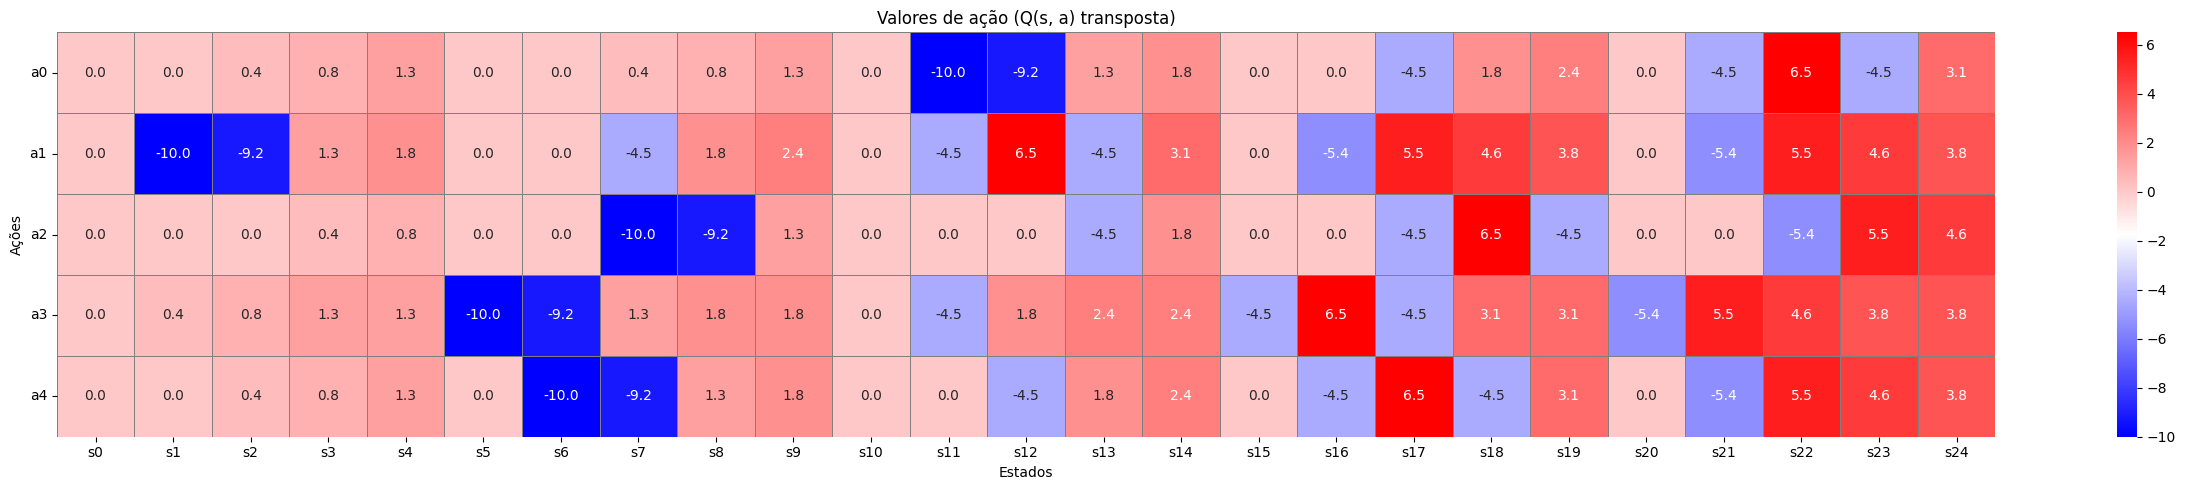


Avaliação com horizonte T = 50
Política convergiu na iteração 14
Política estável após 14 iterações.


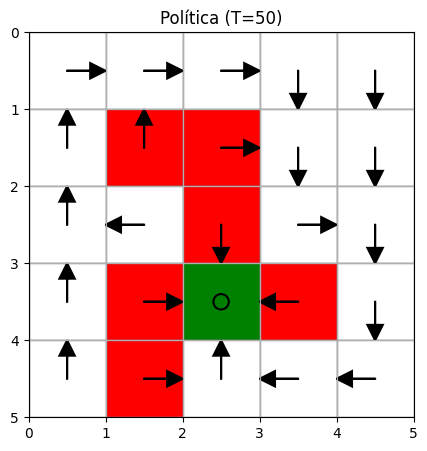

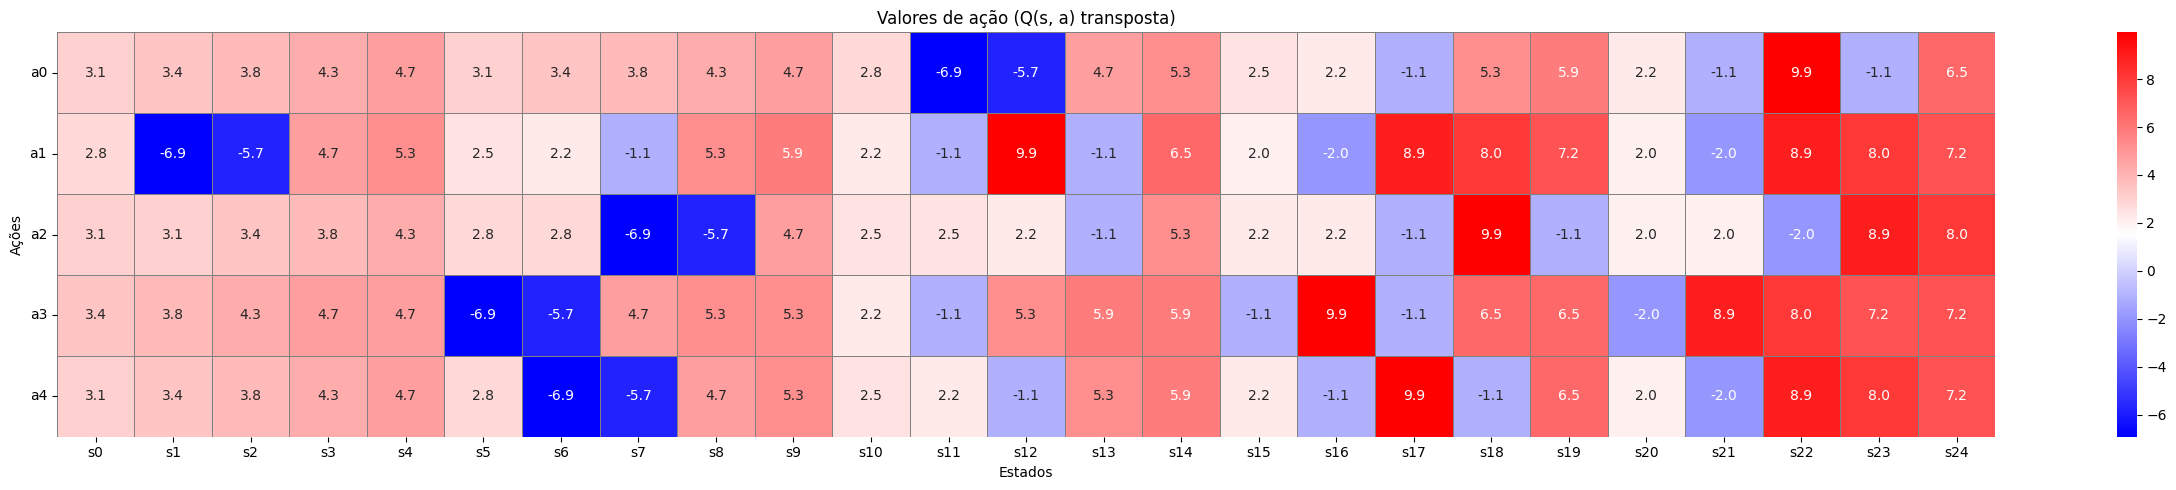


Avaliação com horizonte T = 100
Política convergiu na iteração 12
Política estável após 12 iterações.


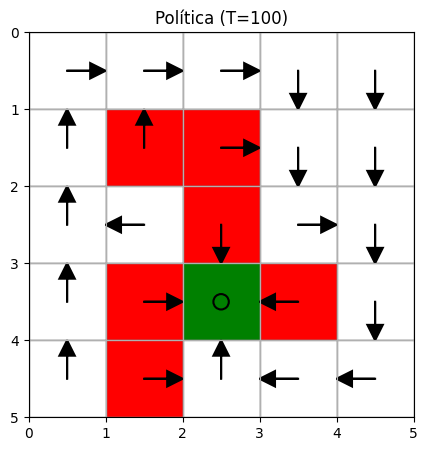

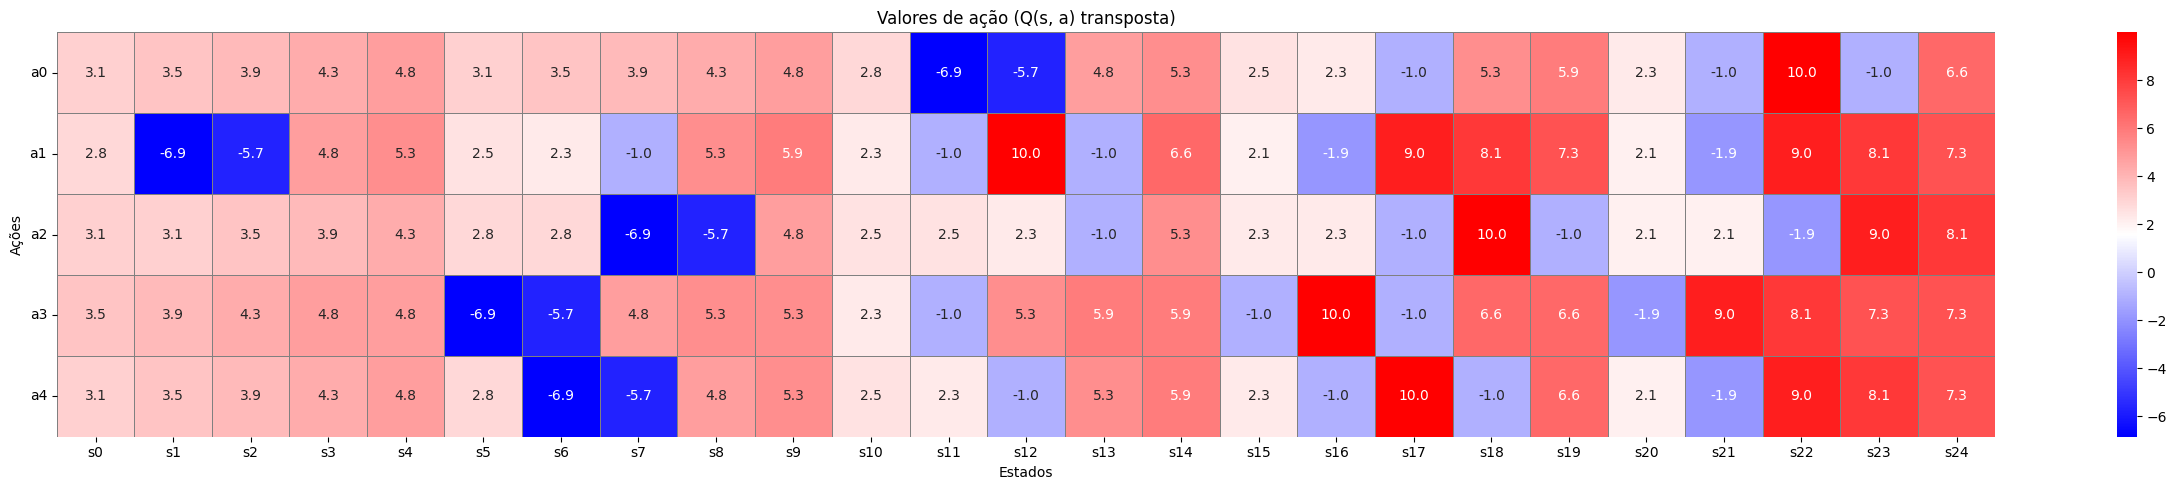

In [ ]:
horizontes_T = [1, 5, 10, 50, 100]

for i, T in enumerate(horizontes_T):
    print(f"\nAvaliação com horizonte T = {T}")
    q_opt, pi_opt, n_iter = mc_basico(
        ambiente,
        gamma=0.9,
        episodios_por_par_s_a=1,
        max_iter=100,
        horizonte_T=T
    )
    print(f"Política estável após {n_iter} iterações.")
    plot_policy(ambiente, pi_opt, titulo=f"Política (T={T})")
    plot_valores_de_acao(q_opt)
